In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import zipfile
import os

# Path to the zip file in your Google Drive
zip_path = '/content/drive/MyDrive/Tumour-20250712T043151Z-1-001.zip'

# Destination path to extract
extract_path = '/content/drive/MyDrive/Tumour'

# Extracting the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete.")


Extraction complete.


In [ ]:
train_dir = "/content/drive/MyDrive/Tumour/Tumour/train"
test_dir = "/content/drive/MyDrive/Tumour/Tumour/test"
valid_dir = "/content/drive/MyDrive/Tumour/Tumour/valid"

In [ ]:
##Data Augumentation

train_datagen = ImageDataGenerator(
    rescale=1./255, #normalize pixel values [0,1]
##parameters of data augumentation
    rotation_range=20, #random rotation -20 or +20 degrees
    width_shift_range=0.2, #random_horiz_shift +/-20 degrees
    height_shift_range=0.2,#random_verti_shift +/-20 degrees
    zoom_range=0.2,  #random zoom 80% to 120%
    horizontal_flip=True, #random horizontal flipping
    vertical_flip=False,#random vertical flipping
    fill_mode='nearest'  #strategy for filling newly created pixels
    )

##No augumentation for valid & test generators and only rescaling

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# set image size and batch size

img_width, img_height = 224, 224 ## as given
batch_size = 32 ## as needed

#create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',   # binary if two classes
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  #Imporatant for evaluating the data set
)

Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


# classnames and number of classes

In [ ]:
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"class names: {class_names}")
print(f"Number of classes: {num_classes}")

class names: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Number of classes: 4


# Building custom model (CNN)

In [ ]:
model = models.Sequential([
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape=(img_height,img_width, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128,(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size
)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 591ms/step - accuracy: 0.6650 - loss: 0.8653 - precision: 0.7475 - recall: 0.5483 - val_accuracy: 0.4458 - val_loss: 1.6071 - val_precision: 0.4638 - val_recall: 0.4000
Epoch 2/10
 1/52 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6562 - loss: 0.9137 - precision: 0.6667 - recall: 0.5000

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6562 - loss: 0.9137 - precision: 0.6667 - recall: 0.5000 - val_accuracy: 0.4583 - val_loss: 1.5338 - val_precision: 0.4822 - val_recall: 0.4229
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 608ms/step - accuracy: 0.6888 - loss: 0.8078 - precision: 0.7668 - recall: 0.6084 - val_accuracy: 0.7417 - val_loss: 0.7082 - val_precision: 0.8082 - val_recall: 0.6583
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.5938 - loss: 0.9924 - precision: 0.6400 - recall: 0.5000 - val_accuracy: 0.7250 - val_loss: 0.7413 - val_precision: 0.7711 - val_recall: 0.6458
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 41s 792ms/step - accuracy: 0.7014 - loss: 0.8039 - precision: 0.7751 - recall: 0.6046 - val_accuracy: 0.7021 - val_loss: 0.7380 - val_precision: 0.7775 - val_recall: 0.6187
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.8438 - loss: 0.6135 - precision: 0.8889 - recall: 0.7500 - val_accuracy: 0.6958 - val_loss: 0.7566 - val_p

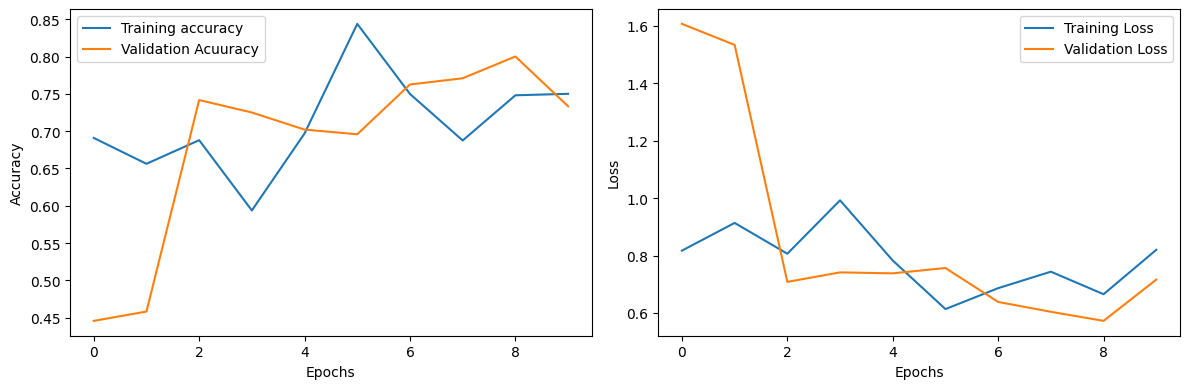

In [ ]:
def plot_history(history):
  plt.figure(figsize=(12,4))

  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], label='Training accuracy')
  plt.plot(history.history['val_accuracy'],label='Validation Acuuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'],label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

plot_history(history)

In [ ]:
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:4f}")
print(f"Test Precision: {test_precision:4f}")
print(f"Test Recall: {test_recall:4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 312ms/step - accuracy: 0.6754 - loss: 0.8937 - precision: 0.7606 - recall: 0.6067

Test Accuracy: 0.723577
Test Precision: 0.790244
Test Recall: 0.658537


In [ ]:
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // batch_size +1)
predicted_classes = np.argmax(predictions, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


In [ ]:
true_classes = test_generator.classes

In [ ]:
print('\n Classification Report:')
print(classification_report(true_classes,predicted_classes, target_names=class_names))

#confusion matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)
print('\n Confusion Matrix:')
print(conf_mat)


 Classification Report:
              precision    recall  f1-score   support

      glioma       0.86      0.69      0.76        80
  meningioma       0.70      0.51      0.59        63
    no_tumor       0.57      0.96      0.71        49
   pituitary       0.83      0.81      0.82        54

    accuracy                           0.72       246
   macro avg       0.74      0.74      0.72       246
weighted avg       0.75      0.72      0.72       246


 Confusion Matrix:
[[55 13  9  3]
 [ 5 32 20  6]
 [ 1  1 47  0]
 [ 3  0  7 44]]


# Using Transfer learning models

In [ ]:
from tensorflow.keras.applications import (VGG16,ResNet50,
                                           MobileNet,InceptionV3,
                                           EfficientNetB0)
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

model_comparison = []

# 1.VGG16

In [ ]:
def evaluate_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy',
                         tf.keras.metrics.Precision(name='precision'),
                         tf.keras.metrics.Recall(name='recall')])

    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

vgg_model, vgg_history = evaluate_vgg16()
model_comparison.append({
    'Model': 'VGG16',
    'Val Accuracy': max(vgg_history.history['val_accuracy']),
    'Val Precision': max(vgg_history.history['val_precision']),
    'Val Recall': max(vgg_history.history['val_recall']),
    'Parameters': f"{vgg_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'Medium-sized datasets'
})

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.3213 - loss: 1.4381 - precision: 0.2380 - recall: 0.0341 - val_accuracy: 0.4821 - val_loss: 1.2283 - val_precision: 0.9315 - val_recall: 0.1355
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 623ms/step - accuracy: 0.4929 - loss: 1.2054 - precision: 0.8844 - recall: 0.1051 - val_accuracy: 0.5498 - val_loss: 1.1144 - val_precision: 0.7292 - val_recall: 0.2092
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 40s 612ms/step - accuracy: 0.5500 - loss: 1.1279 - precision: 0.7743 - recall: 0.1961 - val_accuracy: 0.5936 - val_loss: 1.0356 - val_precision: 0.8243 - val_recall: 0.2430
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 628ms/step - accuracy: 0.6196 - loss: 1.0341 - precision: 0.8412 - recall: 0.2700 - val_accuracy: 0.6375 - val_loss: 0.9737 - val_precision: 0.7760 - val_recall: 0.2968
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 32s 604ms/step - accuracy: 0.6233 - loss: 0.9858 - precision: 0.8109 -

In [ ]:
print(train_generator.samples)
print(len(train_generator))


1695
53


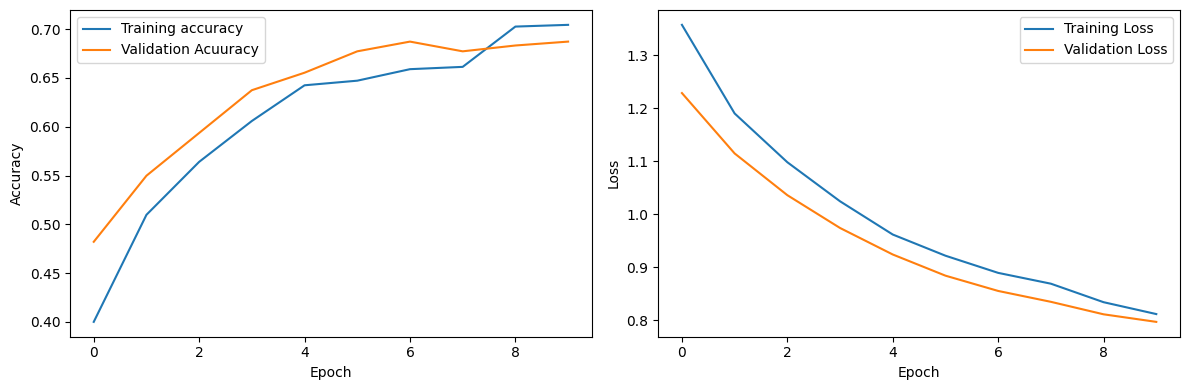

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.7351 - loss: 0.7062 - precision: 0.8479 - recall: 0.5788

Test Accuracy: 0.711382
Test Precision: 0.830065
Test Recall: 0.516260
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step


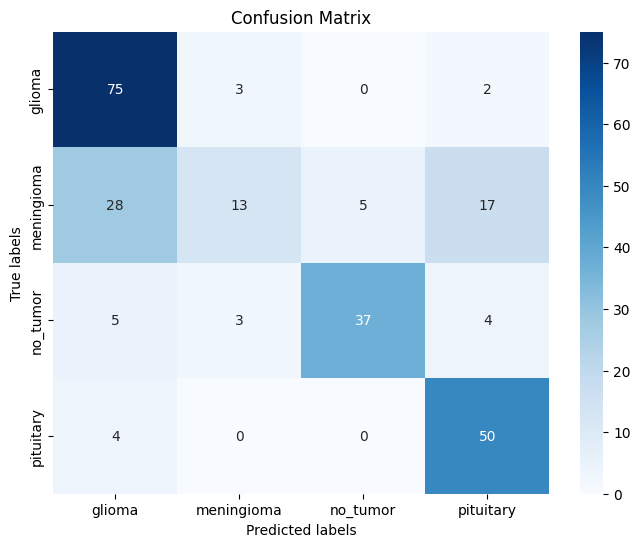

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_history(history) :
  plt.figure(figsize=(12,4))

  plt.subplot(1,2,1)
  plt.plot(history.history['accuracy'], label='Training accuracy')
  plt.plot(history.history['val_accuracy'],label='Validation Acuuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'],label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

plot_history(vgg_history)


#evaluation on test set (assuming a test_generator)
test_generator.reset()
test_loss, test_acc, test_precision, test_recall = vgg_model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:4f}")
print(f"Test Precision: {test_precision:4f}")
print(f"Test Recall: {test_recall:4f}")

#generation predictions
predictions = vgg_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

#true classes
true_classes = test_generator.classes

#confusion matrix
conf_mat = confusion_matrix(true_classes, predicted_classes)

#plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# RESNET50

In [ ]:
def evaluate_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(224,224,3))
    x=tf.keras.applications.resnet50.preprocess_input(inputs)
    x= base_model(x, training=False)
    x= GlobalAveragePooling2D()(x)
    x= Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy',
                         'precision','recall'])
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history
resnet_model, resnet_history = evaluate_resnet50()
model_comparison.append({
    'Model': 'ResNet50',
    'Val Accuracy': max(resnet_history.history['val_accuracy']),
    'Val Precision': max(resnet_history.history['val_precision']),
    'Val Recall': max(resnet_history.history['val_recall']),
    'Parameters': f"{resnet_model.count_params():,}",
    'Inference Time': 'Medium',
    'Best For': 'General purpose'
})





94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 57s 820ms/step - accuracy: 0.2736 - loss: 1.5461 - precision: 0.2579 - recall: 0.0760 - val_accuracy: 0.3944 - val_loss: 1.2831 - val_precision: 0.8333 - val_recall: 0.0299
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 33s 621ms/step - accuracy: 0.3363 - loss: 1.3642 - precision: 0.4436 - recall: 0.0535 - val_accuracy: 0.4502 - val_loss: 1.2474 - val_precision: 0.8500 - val_recall: 0.0677
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 573ms/step - accuracy: 0.4416 - loss: 1.2643 - precision: 0.6893 - recall: 0.1005 - val_accuracy: 0.5080 - val_loss: 1.1787 - val_precision: 0.8421 - val_recall: 0.0637
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 575ms/step - accuracy: 0.4221 - loss: 1.2616 - precision: 0.7485 - recall: 0.0776 - val_accuracy: 0.5498 - val_loss: 1.1611 - val_precision: 0.8378 - val_recall: 0.0618
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 31s 588ms/step - accuracy: 0.4535 - loss: 1.2034 - precision: 0.693

# MobileNet

In [ ]:
def evaluate_mobilenet():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy', 'precision', 'recall'])

    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=10,
        callbacks=[EarlyStopping(patience=3)]
    )

    return model, history

mobilenet_model, mobilenet_history = evaluate_mobilenet()
model_comparison.append({
    'Model': 'MobileNet',
    'Val Accuracy': max(mobilenet_history.history['val_accuracy']),
    'Val Precision': max(mobilenet_history.history['val_precision']),
    'Val Recall': max(mobilenet_history.history['val_recall']),
    'Parameters': f"{mobilenet_model.count_params():,}",
    'Inference Time': 'Fast',
    'Best For': 'Mobile/Edge devices'
})


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4845 - loss: 1.2509 - precision: 0.5618 - recall: 0.3501 - val_accuracy: 0.7669 - val_loss: 0.5881 - val_precision: 0.8413 - val_recall: 0.6972
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 565ms/step - accuracy: 0.7861 - loss: 0.5781 - precision: 0.8391 - recall: 0.7134 - val_accuracy: 0.8347 - val_loss: 0.4386 - val_precision: 0.8671 - val_recall: 0.7928
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 563ms/step - accuracy: 0.8351 - loss: 0.4348 - precision: 0.8741 - recall: 0.7976 - val_accuracy: 0.8566 - val_loss: 0.4073 - val_precision: 0.8809 - val_recall: 0.8247
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 567ms/step - accuracy: 0.8532 - loss: 0.4040 - precision: 0.8851 - recall: 0.8222 - val_accuracy: 0.8765 - val_loss: 0.3572 - val_precision: 0.8958 - val_recall: 0.8566
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 30s 567ms/step - accuracy: 0.8830 - loss: 0.3373 - precision: 0.8999 -

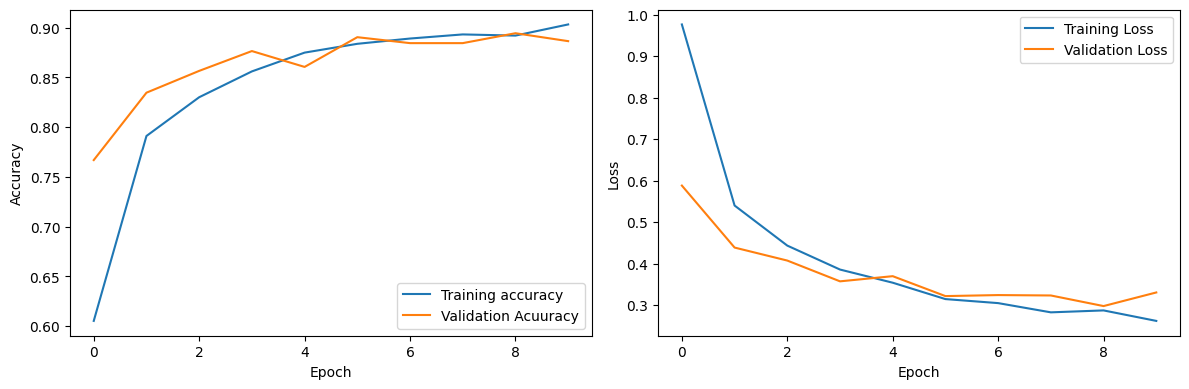

In [ ]:
plot_history(mobilenet_history)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.8673 - loss: 0.3418 - precision: 0.8793 - recall: 0.8563

Test Accuracy: 0.857724
Test Precision: 0.870293
Test Recall: 0.845528
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


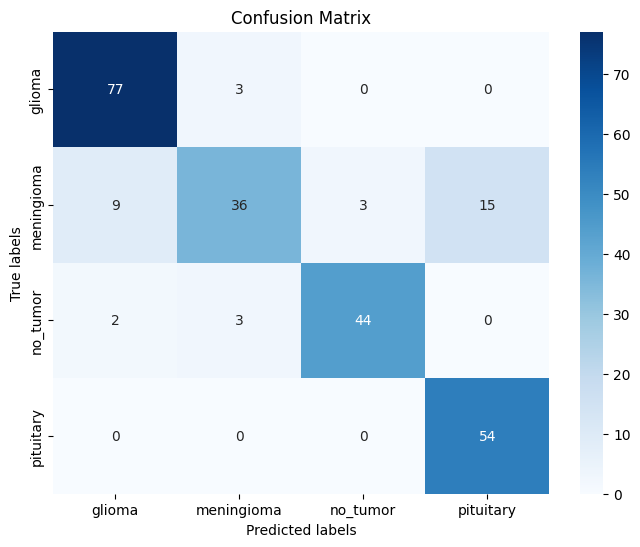

In [ ]:
test_generator.reset()
test_loss, test_acc, test_precision, test_recall = mobilenet_model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:4f}")
print(f"Test Precision: {test_precision:4f}")
print(f"Test Recall: {test_recall:4f}")

#generation predictions for MobileNet
predictions = mobilenet_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

#true classes MobileNet
true_classes = test_generator.classes

#confusion matrix MobileNet
conf_mat = confusion_matrix(true_classes, predicted_classes)

#plot confusion matrix for MobileNet using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import pandas as pd
comparison_df = pd.DataFrame(model_comparison)
comparison_df = comparison_df.sort_values('Val Accuracy', ascending=False)
comparison_df.style.background_gradient(cmap='Blues', subset=['Val Accuracy', 'Val Precision', 'Val Recall'])

,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
2,MobileNet,0.894422,0.904366,0.886454,"3,232,964",Fast,Mobile/Edge devices
0,VGG16,0.687251,0.931507,0.498008,"14,716,740",Medium,Medium-sized datasets
1,ResNet50,0.619522,0.850000,0.177291,"23,595,908",Medium,General purpose


In [ ]:
comparison_df.to_csv('/content/drive/MyDrive/model_comparison.csv', index=False)

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/model_comparison.csv')
df

,Model,Val Accuracy,Val Precision,Val Recall,Parameters,Inference Time,Best For
0,MobileNet,0.894422,0.904366,0.886454,"3,232,964",Fast,Mobile/Edge devices
1,VGG16,0.687251,0.931507,0.498008,"14,716,740",Medium,Medium-sized datasets
2,ResNet50,0.619522,0.850000,0.177291,"23,595,908",Medium,General purpose


The best performing model is:
Model                       MobileNet
Val Accuracy                 0.894422
Val Precision                0.904366
Val Recall                   0.886454
Parameters                  3,232,964
Inference Time                   Fast
Best For          Mobile/Edge devices
Name: 0, dtype: object


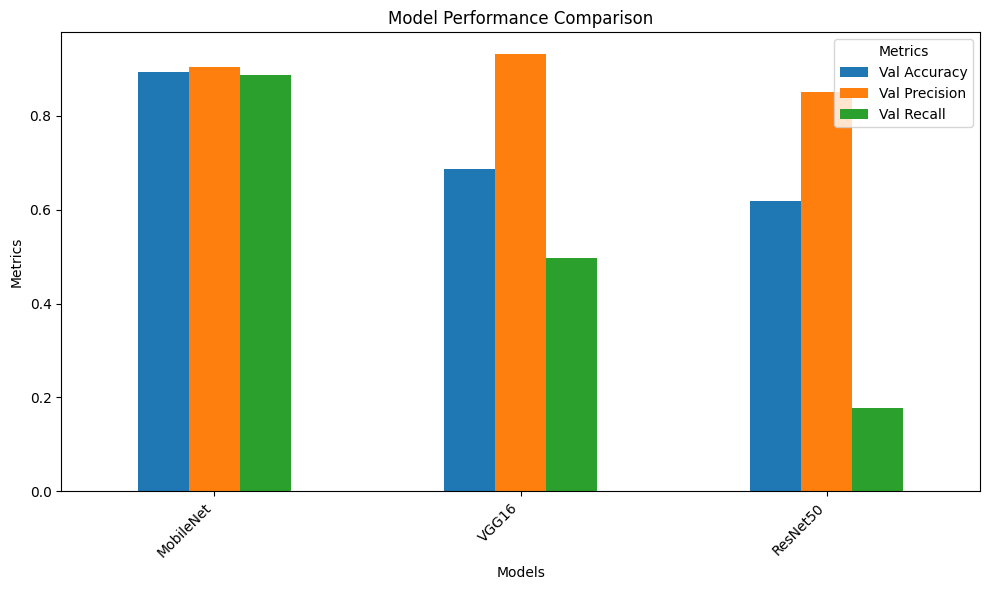

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df= pd.read_csv('/content/drive/MyDrive/model_comparison.csv')

#best model based on validation accuracy
best_model  = df.loc[df['Val Accuracy'].idxmax()]
print(f"The best performing model is:\n{best_model}")

#plotting the bar chart

plt.figure(figsize=(10,6))
df.plot(x='Model', y=['Val Accuracy','Val Precision','Val Recall'],kind='bar', ax=plt.gca())
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Model Performance Comparison')

plt.xticks(rotation=45,ha='right')
plt.legend(title='Metrics')
plt.tight_layout()

plt.show()


# Save the model


In [ ]:
mobilenet_model.save('/content/drive/MyDrive/Tumour/Tumour/mobilenet_model.h5')

# Streamlit App

In [ ]:
!pip install streamlit numpy pillow tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.8 MB/s eta 0:00:00


In [ ]:
%%writefile tumour_app.py

import streamlit as st
import numpy as np
import PIL import image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import os

classes = ['glioma','meningioma','no_tumour','pituitary']

#load the trained model
@st.catch_resource
def load_custom_model():
  model_path = '/content/drive/MyDrive/Tumour/Tumour/mobilenet_model.h5'
  if not os.path.exists(model_path):
    st.error(f"Model file not found at path: {model_path}")
    return None
  return load_model(model_path)

model = load_custom_model()

#streamlit app
st.title("🎣 Custom Brain Tumor Classifier")
st.write("Upload an image of a brain tumor to classify it.")

#file uploader
uploaded_file = st.file_uploader("Choose an image...",
                                 type=["jpg","jpeg","png"])
if uploaded_file is not None:
  #Display the uploaded image
  image = Image.open(uploaded_file)
  st.image(image, caption='Uploaded Image', use_column_width=True)

  #preprocess the image
  image = image.resize((224,224))
  image_array = img_to_array(image)
  image_array /= 255.0
  image_array = np.expand_dims(image_array, axis=0)

  #make prediction
  with st.spinner("Identifying tumour.."):
    prediction = model.predict(image_array)
    predicted_class = classes[np.argmax(prediction)]
    confidence = np.max(prediction)

#display results
st.subheader("Prediction Results:")
st.success(f"Tumour: {predicted_class}")
st.info(f"Confidence: {confidence*100:.2f}")

#show all class probabilities
st.subheader("All Class probabilities:")
for i,(cls,prob) in enumerate(zip(classes,prediction[0])):
  st.write(f"{cls}: {prob*100:.2f}%")
  st.progress(float(prob))






Writing tumour_app.py


In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.126.148.151


In [ ]:
! streamlit run tumour_app.py & npx localtunnel --port 8501

/bin/bash: line 1: streamlit: command not found
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹your url is: https://twelve-bikes-shout.loca.lt
/root/.npm/_npx/75ac80b86e83d4a2/node_modules/localtunnel/bin/lt.js:81
    throw err;
    ^

Error: connection refused: localtunnel.me:32943 (check your firewall settings)
    at Socket.<anonymous> (/root/.npm/_npx/75ac80b86e83d4a2/node_modules/localtunnel/lib/TunnelCluster.js:52:11)
    at Socket.emit (node:events:524:28)
    at emitErrorNT (node:internal/streams/destroy:169:8)
    at emitErrorCloseNT (node:internal/streams/destroy:128:3)
    at process.processTicksAndRejections (node:internal/process/task_queues:82:21)

Node.js v20.19.0
⠙